In [1]:
# !pip install pypolycontain

In [2]:
!pip install git+https://github.com/sadraddini/pypolycontain.git

  Cloning https://github.com/sadraddini/pypolycontain.git to /tmp/pip-req-build-7dlhega0
  Running command git clone --filter=blob:none --quiet https://github.com/sadraddini/pypolycontain.git /tmp/pip-req-build-7dlhega0
  Resolved https://github.com/sadraddini/pypolycontain.git to commit a9aa1a6cff766c06fdb94aaca89a26471b7a9cb4
  Preparing metadata (setup.py) ... done
  Created wheel for pypolycontain: filename=pypolycontain-1.4-py3-none-any.whl size=27913 sha256=a2397d500bc8eaeb618a139c17ea0ce5dd218a95f546349ab9f18781d5cd5887
  Stored in directory: /tmp/pip-ephem-wheel-cache-l0a5fex_/wheels/35/f5/71/27eb24d2a4b3d9e653bfc1801694f70ba5d496d1765d107308
Successfully built pypolycontain


In [3]:
!pip install drake

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 2.4 MB/s eta 0:00:00


In [4]:
# install dependencies
!pip install casadi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 9.2 MB/s eta 0:00:00


# Safe Autonomy Tutorial: Motion Planning

In this tutorial, you will get familiar with different optimization-based motion planning techniques to obtain a collision-free trajectory for a dynamical system. We will reuse parts from the 0th tutorial, so you should be familiar the optimization problem formulation. The overall assignment is seperated into three parts:

1.   E-Level: Optimization-based motion planning Intro
2.   C-Level: Optimization-based motion planning in dynamic environments + Feedback motion primitive generation
3.   A-Level: A*-based motion planning with feedback motion primitives



In [5]:
import numpy as np
from math import *

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from copy import deepcopy, copy

## Optimization-based Motion Planning: Static Obstacles

The goal of this section is to find a dynamically feasible trajectory from an initial state to a goal state while optimizing a performance measure subject to obstacle avoidance constraints. The standard formulation of an optimization (or optimal control) problem can be formulated as

$$
\begin{aligned}
	\min_{\mathbf{u}_{1:N-1}, \mathbf{x}_{1:N}} \quad &\sum_{t=1}^{N} J(\mathbf{x}_t, \mathbf{u}_t)\\
	\textrm{s.t.  } \quad  &\mathbf{x}_{t+1} = \mathbf{f}\left(\mathbf{x}_t, \mathbf{u}_t\right) \hspace{0.5cm} &&\forall t = 1, \cdots, N-1\\
  &\mathbf{x}_{t}  \notin \mathcal{X}_{obs} \hspace{0.5cm} &&\forall t = 1, \cdots, N\\
  & \mathbf{u}_t \in \mathcal{U} &&\forall t = 1, \cdots, N-1\\
	& \mathbf{x}_N \in \mathcal{X}_g, \mathbf{x}_0 = \mathbf{x}(t_0)
    \end{aligned}.
$$
where $J$ is the stage cost and $\mathcal{X}_{obs}$ is the set of obstacle positions.

First, we define the environment in which our robot (drone from 0th tutorial) is operating. This 2d environment consists of a number of polygon obstacle regions. A single convex polygon is given as a list of points.

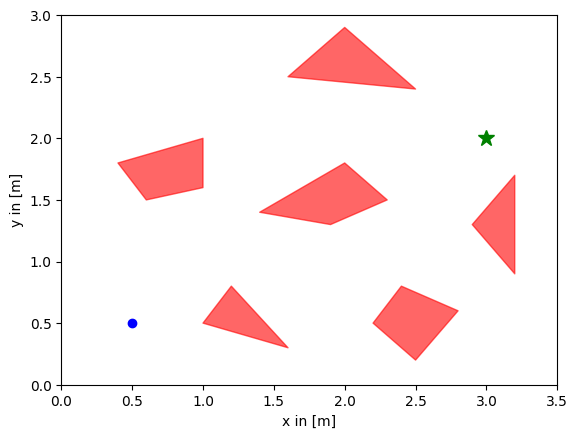

In [6]:
import matplotlib.pyplot as plt

# Initial state of the robot
x0 = [0.5, 0.5, 0.]

# Goal state
xG = [3., 2., 0.]

# For collision checking we will overapproximate the robot with a circle of radius r
r = 0.15

# Define obstacles in the environment (Each obstacle is defined by a list of its vertex positions)
obstacles = []
obstacles.append([[1., 0.5], [1.2, 0.8], [1.6, 0.3]])
obstacles.append([[0.6, 1.5], [0.4, 1.8], [1., 2.], [1., 1.6]])
obstacles.append([[1.4, 1.4], [2., 1.8], [2.3, 1.5], [1.9, 1.3]])
obstacles.append([[2.9, 1.3], [3.2, 1.7], [3.2, 0.9]])
obstacles.append([[2.5, 0.2], [2.2, 0.5], [2.4, 0.8], [2.8, 0.6]])
obstacles.append([[1.6, 2.5], [2., 2.9], [2.5, 2.4]])


# Plot environment
fig, ax = plt.subplots()

patches = []
for obs in obstacles:
    p = Polygon(obs)
    patches.append(p)


p_col = PatchCollection(patches, alpha=0.6)
p_col.set_color([1, 0, 0])
ax.add_collection(deepcopy(p_col))
ax.plot([x0[0]], [x0[1]], marker='o', color="b")
ax.plot([xG[0]], [xG[1]], marker='*', color="g", markersize=12)
ax.set_xlim([0,3.5])
ax.set_ylim([0,3])
ax.set_xlabel("x in [m]")
ax.set_ylabel("y in [m]")
plt.show()


Typically, we distinguish between different optimization techniques such as gradient-based or sampling-based optimization. There are lots of different reasons why one approach is more suitable than the other one which depends heavily on the problem setting. In the following, we will focus on gradient-based approaches in which it is crucial to have smooth cost functions and constraints. If cost or constraint functions are nonsmooth, gradient-based approaches may fail as the gradient does not exist at discontinuities. In case you want to learn more about numerical optimization in general, I can recommend $\href{https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf}{this}$ (Convex Optimization) and $ \href{https://algorithmsbook.com/optimization/files/optimization.pdf}{this}$ (Algorithms for Optimization) book.


Ideally, to set up the optimization problem, we would like to say something like "distance between robot and polygons greater than XX". However, the distance function between a polygon and a point has a nonsmooth gradient which will complicate standart optimization techniques. Therefore, we will introduce a commonly used smooth approximation: Minimum Volume Enclosing Ellipsoids (MVEE). An ellipsoid can be described by

\begin{align}
\mathcal{E} = \left\{ \mathbf{x} \in \mathbb{R}^n \mid \left(\mathbf{x} - \mathbf{c}\right)^T \mathbf{A} \left(\mathbf{x} - \mathbf{c}\right) \leq 1\right\}
\end{align}
where $\mathbf{A} \in \mathbb{R}^{n \times n}$ and $\mathbf{c} \in \mathbb{R}^n$ is the center of the ellipsoid. There are a lot of different approaches to obtain the minimmum ellipse that contains a given polygon $\mathcal{P}$. One of these approaches is implemented in the following, if you would like to read up on that, I would recommend Chapter 8.4.1 of "Convex Optimization".



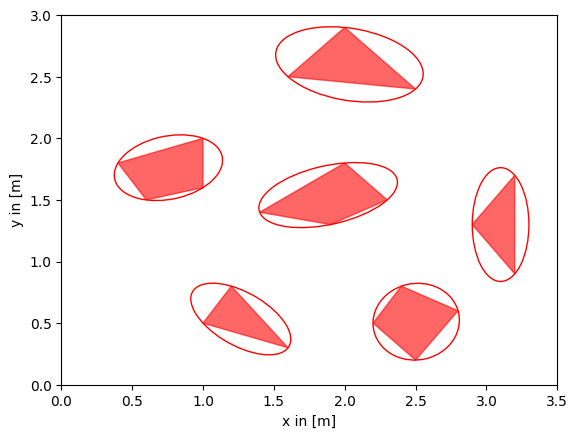

In [7]:
from matplotlib.patches import Ellipse

# MVEE algorithm
def mvee(points, tol=0.0001):
    """
    Finds the ellipse equation in "center form"
    (x-c).T * A * (x-c) = 1
    """
    N, d = points.shape
    Q = np.column_stack((points, np.ones(N))).T
    err = tol+1.0
    u = np.ones(N)/N
    while err > tol:
        X = np.dot(np.dot(Q, np.diag(u)), Q.T)
        M = np.diag(np.dot(np.dot(Q.T, np.linalg.inv(X)), Q))
        jdx = np.argmax(M)
        step_size = (M[jdx]-d-1.0)/((d+1)*(M[jdx]-1.0))
        new_u = (1-step_size)*u
        new_u[jdx] += step_size
        err = np.linalg.norm(new_u-u)
        u = new_u
    c = np.dot(u, points)
    A = np.linalg.inv(np.dot(np.dot(points.T, np.diag(u)), points)
               - np.multiply.outer(c, c))/d
    return A, c

# initialize list of ellipsoids [(A_1, c_1), ...]
obstacle_ellipsoids = []

for obs in obstacles:
    A, c = mvee(np.array(obs))
    obstacle_ellipsoids.append((A, c))


# Visualize environment
fig, ax = plt.subplots()

ax.add_collection(deepcopy(p_col))

ellipses = []
for (A, c) in obstacle_ellipsoids:
    # Eigendecomposition of A
    Lambda, R = np.linalg.eig(A)
    width = 2 * sqrt(1 / Lambda[0])
    height = 2 * sqrt(1 / Lambda[1])
    angle = atan2(R[1, 0], R[0, 0]) * 180 / pi
    ellipse = Ellipse(c, width, height, angle=angle, facecolor='none')
    ellipse.set_edgecolor([1, 0, 0])
    ellipses.append(ellipse)
    ax.add_artist(copy(ellipse))


ax.set_xlim([0,3.5])
ax.set_ylim([0,3])
ax.set_xlabel("x in [m]")
ax.set_ylabel("y in [m]")
plt.show()


We will now focus on formulating our constraint $\mathbf{x}_t \notin \mathcal{X}_{obs} \forall t=0,\dots,N$. Since MVEE's are strictly overapproximating the polygons $\mathcal{P}$ it is true that $\mathbf{x}_t \notin \bigcup_{i=1}^M \mathcal{E} \implies \mathbf{x}_t \notin \mathcal{X}_{obs}$, where $M=6$ is the number of obstacles. However, in this formulation, we treat the robot as a point in 2D space which is not capturing the robot's volume. In this assignment, we approximate the robots collision box by a circle of radius $r$ and position $\mathbf{x}$.

Hence, in order to formulate proper obstacle avoidance constraints, we would like to obtain the enlarged ellipsoids $\tilde{\mathcal{E}}_i$ such that
\begin{align}
\mathbf{x}_t \notin \tilde{\mathcal{E}}_i \implies \mathrm{dist}\left(\mathbf{x}_t, \mathcal{E}\right) \geq r
\end{align}
holds. The key ingredient to obtain the enlarged ellipses is to obtain the minkowski sum $\tilde{\mathcal{E}}_i = \mathcal{E} \bigoplus \mathcal{B}_2(r)$ where $\mathcal{B}_2(r)$ is a circle of radius $r$. In the following, create a list of tuples $enlarged_ellipses = [(\tilde{\mathbf{A}}_1, \tilde{\mathbf{c}}_1), \dots, (\tilde{\mathbf{A}}_M, \tilde{\mathbf{c}}_M)]$ that contains the enlarged ellipses. Hint: Use an Eigendecomposition to obtain the ellipse equation in normal form $\left(\frac{x}{a}\right)^2 + \left(\frac{y}{b}\right)^2 = 1$ where $a, b$ are half the length of the major and minor axes.

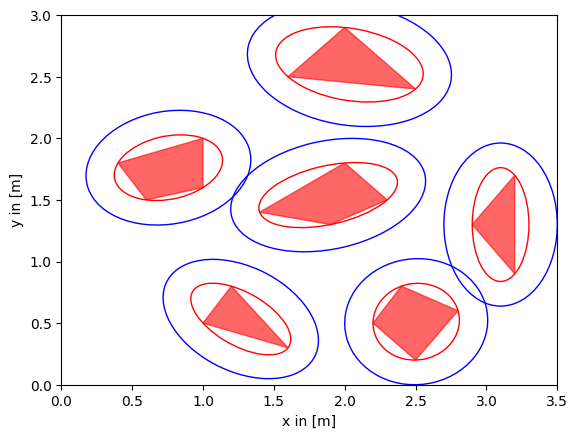

In [8]:
# radius robot
r = 0.2

# init empty lists
enlarged_ellipses = []

# PUT YOUR CODE HERE
for (A, c) in obstacle_ellipsoids:
  Lambda, R = np.linalg.eig(A) # eigendecomposition of A => eigenvalue Lambda and eigenvector matrix R

  a = sqrt(1 / Lambda[0]) # radius of the obstacles
  b = sqrt(1 / Lambda[1])

  a_enlarged = a + r
  b_enlarged = b + r

  # A = R \Sigma R^T => A' = R \Sigma' R^T
  Lambda_enlarged = np.array([1/(a_enlarged ** 2), 1/(b_enlarged ** 2)])
  A_enlarged = R @ np.diag(Lambda_enlarged) @ R.T

  enlarged_ellipses.append((A_enlarged, c))


# generate plot objects
enlarged_ellipses_patches = []
for (A, c) in enlarged_ellipses:
  Lambda, R = np.linalg.eig(A)
  width = 2 * sqrt(1 / Lambda[0])
  height = 2 * sqrt(1 / Lambda[1])
  angle = atan2(R[1, 0], R[0, 0]) * 180 / pi
  ellipse = Ellipse(c, width, height, angle=angle, facecolor='none')
  ellipse.set_edgecolor([0, 0, 1])
  enlarged_ellipses_patches.append(ellipse)

fig, ax = plt.subplots()

for e_ in enlarged_ellipses_patches:
    ax.add_artist(copy(e_))

for e in ellipses:
    ax.add_artist(copy(e))

ax.add_collection(deepcopy(p_col))
ax.set_xlim([0,3.5])
ax.set_ylim([0,3])
ax.set_xlabel("x in [m]")
ax.set_ylabel("y in [m]")
plt.show()


Now that we have obtained a smooth expression for collision checking with the obstacles based on just the robot position $\mathbf{x}_t$, we can formulate our motion planning problem in `casadi`. Implement the optimization problem for a quadratic cost function of the form
\begin{align}
J\left(\mathbf{x}_t, \mathbf{u}_t\right) = \left(\mathbf{x}_t - \mathbf{x}_G\right)^T \mathbf{Q} \left(\mathbf{x}_t - \mathbf{x}_G\right) + \mathbf{u}^T \mathbf{R} \mathbf{u}_t  
\end{align}
for $\mathbf{Q} = \mathbf{I}_{3 \times 3}$ and $\mathbf{R} = \mathrm{diag}([2, 2])$. The dynamics model is given by
$$
\begin{bmatrix}
    x_{k+1}\\
    y_{k+1}\\
    \theta_{k+1}
    \end{bmatrix} = \begin{bmatrix}
    x_k - u_1 \Delta t sin(\theta)\\
    y_k + u_1 \Delta t cos(\theta)\\
     \theta _k + u_2 \Delta t
\end{bmatrix}.
$$
and the feasible control set is defined as $\mathcal{U} = \left\{[u_1, u_2]^T \in \mathbb{R}^2 \mid 0 \leq u_1 \leq 1\right\}$. Hint: Remember to use `casadi` functions for the trigonometric functions.

In [9]:
import casadi

# use casadi types to perform computations
opti = casadi.Opti()

# Trajectory length
N = 100
dt = 0.1

# PUT YOUR CODE HERE
def disc_dynamics(xk, uk, dt):
  x_k1 = xk[0] - uk[0] * dt * casadi.sin(xk[2])
  y_k1 = xk[1] + uk[0] * dt * casadi.cos(xk[2])
  theta_k1 = xk[2] + uk[1] * dt
  return x_k1, y_k1, theta_k1

csd_xg = casadi.DM(xG) # goal

X = opti.variable(3, N+1)   # [x, y, theta]
U = opti.variable(2, N)     # [u1, u2]

# subject to
# initial condition
opti.subject_to(X[:, 0] == x0)
# input condition
opti.subject_to(U[0, :] >= 0)
opti.subject_to(U[0, :] <= 1)

Q = casadi.DM.eye(3)
R = casadi.DM.eye(2)
# if you wanna change the weight
# => casadi.diag(casadi.DM([a, b, c]))

# cost function
J_c = 0
for k in range(N):
    xk = X[:, k]
    uk = U[:, k]

    dx = xk - csd_xg
    J_c += casadi.mtimes([dx.T, Q, dx]) + casadi.mtimes([uk.T, R, uk])

    # subject to
    # dynamical condition(x[k+1] = f(x[k])
    x_k1, y_k1, theta_k1 = disc_dynamics(xk, uk, dt)
    x_next = casadi.vertcat(x_k1, y_k1, theta_k1) # vector type
    opti.subject_to(X[:, k+1] == x_next)

# terminal condition
# terminal weight is kinda important, 500 did not work
Q_f = 1000 * casadi.DM.eye(3)
dx_N = X[:, N] - csd_xg # gap between x at the time of N and goal
J_c += casadi.mtimes([dx_N.T, Q_f, dx_N])


# subject to
# obstacle condition
for k in range(N+1):
  p = X[0:2, k] # position of the robot at the time of k
  for (A, c) in enlarged_ellipses:
    Ai = casadi.DM(A)
    ci = casadi.DM(c)
    d_i = p - ci
    opti.subject_to(casadi.mtimes([d_i.T, Ai, d_i]) >= 1.0) # outside of the ellipsoid


opti.minimize(J_c)
opti.solver('ipopt') # nonlinear => qp unsolvable => tpopt
sol = opti.solve()
traj = sol.value(X)
opt_u = sol.value(U)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1103
Number of nonzeros in inequality constraint Jacobian.:     1412
Number of nonzeros in Lagrangian Hessian.............:      704

Total number of variables............................:      503
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      303
Total number of inequality c

After solving the optimization problem, we can visualize our results!

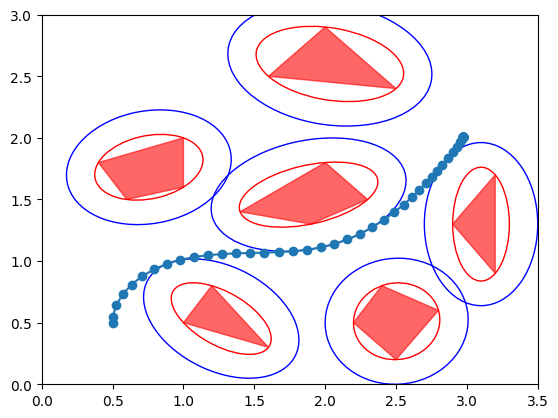

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(traj[0, :], traj[1, :], marker='o')

for e_ in enlarged_ellipses_patches:
    ax1.add_artist(copy(e_))

for e in ellipses:
    ax1.add_artist(copy(e))


ax1.add_collection(copy(p_col))
ax1.set_xlim([0,3.5])
ax1.set_ylim([0,3])
plt.show()

ax1.set_xlabel("x in [m]")
ax1.set_ylabel("y in [m]")

plt.show()

# it is stuck even though the optimization says "optimal solution found" because it only says J is minimized.
# the solution gets local optimization

**Aaand also animate!**

In [11]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from math import *

def animation_func(i, data):
    x = data[0]
    y = data[1]
    theta = data[2]
    # Drone dimension: width l
    l = 0.3
    p1 = [x[i] + cos(theta[i]) * l/2, y[i] + sin(theta[i]) * l/2]
    p2 = [x[i] - cos(theta[i]) * l/2, y[i] - sin(theta[i]) * l/2]
    line1.set_xdata([p1[0], p2[0]])
    line1.set_ydata([p1[1], p2[1]])
    # Plot trajectory
    pt, = ax.plot([x[i]], [y[i]], "g.", markersize=1)

    ax.add_collection(deepcopy(p_col))

    return line1, pt

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])
line1, = ax.plot([x0[0]-0.15, x0[0] + 0.15], [0., 0.], 'ko-', lw=1.5, markersize=5)

x_data = traj[0, :]
y_data = traj[1, :]
theta_data = traj[2, :]
animation = FuncAnimation(fig, animation_func, fargs=((x_data, y_data, theta_data),),
                          frames=N, interval=50, blit=True)
# plt.show()
HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>

## Optimization-based Motion Planning: Dynamic Obstacles
Now we will start with moving obstacles! In this case we will assume that the obstacles start in the previous configuration and have a constant velocity in one direction. In the following, create a list of the obstacles at each timestep $t = 0, \dots, N$.

In [12]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook

# velocity vectors in xy-plane
velocity_dirs = [[1., 0.], [1., 0.4], [0.4, -1.], [-1, 0.5], [-0.1, 1.], [1., 0.2]]

# velocity magnitudes
velocities = [0.1, 0.15, 0.1, 0.4, 0.3, 0.05]

# list of obstacles at each timestep
timed_obstacles = []
timed_obstacles.append(deepcopy(obstacles))

for k in range(1, N):
    # PUT YOUR CODE HERE
    # \Delta x = v_dir/|v_dir| velocity \Delta t
    # updating dynamic obstacle
    current_obs = []
    prev_obs_list = timed_obstacles[k-1]

    for j, obs in enumerate(prev_obs_list):
        dir_vec = np.array(velocity_dirs[j])
        dir_unit = dir_vec / np.linalg.norm(dir_vec)  # render np.array type, and do normalization

        Delta_x = dir_unit * velocities[j] * dt

        # shift each vertex
        new_obs = (np.array(obs) + Delta_x).tolist()
        current_obs.append(new_obs)

    timed_obstacles.append(current_obs)

def animation_obstacles(i):
    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)

    return moving_patches,


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])

moving_patches = []
for p in patches:
  moving_patches.append(Polygon(p.get_xy()))

for p in moving_patches:
    p.set_color([1, 0, 0])
    ax.add_patch(p)

animation = FuncAnimation(fig, animation_obstacles, frames=N, interval=50, blit=True)

HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>

To use the same constraint formulations as before, we need the ellipsoidal overapproximations over time!

In [13]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook


# list of list of ellipses at each time step
timed_ellipses = []

# PUT YOUR CODE HERE
timed_ellipses.append(deepcopy(enlarged_ellipses)) # copying the elipsoid at t = 0
for k in range(1, N+1): # moving the center of elipsoid
    ellipses_k = []
    for j, (A, c0) in enumerate(enlarged_ellipses): # each obstacle
        dir_vec = np.array(velocity_dirs[j])
        dir_unit = dir_vec / np.linalg.norm(dir_vec) # normalization
        step = dir_unit * velocities[j] * dt # delta moving
        c_k = c0 + k * step # moving
        ellipses_k.append((A, c_k)) # move just the center and leave A
    timed_ellipses.append(ellipses_k)

# Animations
def animation_ellipses(i):
    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)

    for j, e in enumerate(moving_ellipses):
        e.set_center(timed_ellipses[i][j][1])

    return moving_patches, moving_ellipses,


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])

# moving_patches = copy(patches)
moving_patches = []
for p in patches:
  moving_patches.append(Polygon(p.get_xy()))
# moving_ellipses = copy(enlarged_ellipses_patches
moving_ellipses = []
for e in enlarged_ellipses_patches:
  moving_ellipses.append(Ellipse(e.get_center(), e.width, e.height, angle=e.angle, facecolor='none'))

for p in moving_patches:
    p.set_color([1, 0, 0])
    ax.add_patch(p)

for e in moving_ellipses:
    e.set_edgecolor([0, 0, 1])
    ax.add_artist(e)

animation = FuncAnimation(fig, animation_ellipses, frames=N, interval=50, blit=True)

# plt.show()
HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>

**We're almost there!** Formulate the optimization problem in the case of moving obstacles!

In [14]:
#PUT YOUR CODE HERE
import casadi

opti = casadi.Opti()

# Trajectory length
N = 100
dt = 0.1

# PUT YOUR CODE HERE
def disc_dynamics(xk, uk, dt):
  x_k1 = xk[0] - uk[0] * dt * casadi.sin(xk[2])
  y_k1 = xk[1] + uk[0] * dt * casadi.cos(xk[2])
  theta_k1 = xk[2] + uk[1] * dt
  return x_k1, y_k1, theta_k1

Q = casadi.DM.eye(3)
R = casadi.DM.eye(2)
csd_xg = casadi.DM(xG)
X = opti.variable(3, N+1)
U = opti.variable(2, N)


opti.subject_to(X[:, 0] == x0)
opti.subject_to(U[0, :] >= 0)
opti.subject_to(U[0, :] <= 1)

# cost function
J_c = 0
for k in range(N):
    xk = X[:, k]
    uk = U[:, k]
    dx = xk - csd_xg
    J_c += casadi.mtimes([dx.T, Q, dx]) + casadi.mtimes([uk.T, R, uk])

    x_k1, y_k1, theta_k1 = disc_dynamics(xk, uk, dt)
    x_next = casadi.vertcat(x_k1, y_k1, theta_k1)
    opti.subject_to(X[:, k+1] == x_next)


Q_f = 1000 * casadi.DM.eye(3)
dx_N = X[:, N] - csd_xg
J_c += casadi.mtimes([dx_N.T, Q_f, dx_N])

# obstacle moving
for k in range(N+1):
  p = X[0:2, k]   # x,y
  for (A, ck) in timed_ellipses[k]:
    Ai = casadi.DM(A)
    cki = casadi.DM(ck)
    d = p - cki
    opti.subject_to(casadi.mtimes([d.T, Ai, d]) >= 1.0)


opti.minimize(J_c)
opti.solver('ipopt')
sol = opti.solve()
traj = sol.value(X)
opt_u = sol.value(U)


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1103
Number of nonzeros in inequality constraint Jacobian.:     1412
Number of nonzeros in Lagrangian Hessian.............:      704

Total number of variables............................:      503
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      303
Total number of inequality constraints...............:      806
        inequality constraints with only lower bounds:      706
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      100

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4300000e+04 5.00e-01 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Visualization of the obtained trajectory.

In [15]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from math import *

def animation_func(i, data):
    x = data[0]
    y = data[1]
    theta = data[2]
    # Drone dimension: width l
    l = 0.3
    p1 = [x[i] + cos(theta[i]) * l/2, y[i] + sin(theta[i]) * l/2]
    p2 = [x[i] - cos(theta[i]) * l/2, y[i] - sin(theta[i]) * l/2]
    line1.set_xdata([p1[0], p2[0]])
    line1.set_ydata([p1[1], p2[1]])
    # Plot trajectory
    pt, = ax.plot([x[i]], [y[i]], "g.", markersize=1)

    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)

    return line1, pt, moving_patches,

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])
line1, = ax.plot([x0[0]-0.15, x0[0] + 0.15], [0., 0.], 'ko-', lw=1.5, markersize=5)

moving_patches = []
for p in patches:
  moving_patches.append(Polygon(p.get_xy()))

for p in moving_patches:
    p.set_color([1, 0, 0])
    ax.add_patch(p)

x_data = traj[0, :]
y_data = traj[1, :]
theta_data = traj[2, :]
animation = FuncAnimation(fig, animation_func, fargs=((x_data, y_data, theta_data),),
                          frames=N, interval=50, blit=True)
# plt.show()
HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>